In [ ]:
!pip install pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 57.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.optim.lr_scheduler import LambdaLR
from torch import nn
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
from torch.utils.data import Dataset, WeightedRandomSampler
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import vgg11, VGG11_Weights

import tqdm

import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
def make_class_paths(root):
    norm_directory = os.path.join(root, 'normal')
    norm_images_paths = [
        os.path.join(norm_directory, p) for p in os.listdir(norm_directory)]

    pneum_directory = os.path.join(root, 'pneumonia')
    virus_images_paths = [os.path.join(pneum_directory, p) for p in os.listdir(pneum_directory) if 'virus' in p]
    bacteria_images_paths = [os.path.join(pneum_directory, p) for p in os.listdir(pneum_directory) if 'bacteria' in p]
    images_filepaths = norm_images_paths + virus_images_paths + bacteria_images_paths
    return images_filepaths

In [ ]:
train_paths = make_class_paths('./train')
val_paths = make_class_paths('./val')
test_paths = make_class_paths('./test')

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if 'virus' in image_filepath or 'bacteria' in image_filepath:
            label = 1.0
        else:
            label = 0.0

        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [ ]:
train_transform = A.Compose(
    [   A.SmallestMaxSize(max_size=224),
        A.RandomCrop(height=224, width=224),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [   A.SmallestMaxSize(max_size=224),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
        ToTensorV2(),
    ]
)

train_dataset = PneumoniaDataset(train_paths, train_transform)
val_dataset = PneumoniaDataset(val_paths, val_transform)
test_dataset = PneumoniaDataset(test_paths, val_transform)

class_weights = [3, 1]
sample_weights = [0] * len(train_dataset)
for i, (sample, label) in enumerate(tqdm.tqdm(train_dataset)):
     sample_weights[i] = class_weights[int(label)]

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16,
    sampler=WeightedRandomSampler(torch.FloatTensor(sample_weights),
                                len(sample_weights), replacement=False))

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=False)

In [ ]:
class XRayNet(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Identity()

        for param in self.model.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=1, bias=True),
            nn.Sigmoid()
          )

        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=2e-5)

        self.loss = nn.BCELoss()

    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            features = self.model(x)
        return self.classifier(features)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds.view(-1), target.float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds.view(-1), target.float())
        sigmoid = nn.Sigmoid()

        acc = accuracy((preds > 0.5).float().view(-1), target,
                task='binary')
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
xray_classifier = XRayNet()

In [ ]:
trainer = pl.Trainer(accelerator='cuda', max_epochs=5)
trainer.fit(xray_classifier, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | model      | VGG        | 9.2 M 
1 | classifier | Sequential | 119 M 
2 | loss       | BCELoss    | 0     
------------------------------------------
119 M     Trainable params
9.2 M     Non-trainable params
128 M     Total params
515.082   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
labels = torch.Tensor()
true_labels = torch.Tensor()

with torch.no_grad():
    xray_classifier.eval()
    for images, target in tqdm.tqdm(test_dataloader):
        preds = xray_classifier.forward(images)

        labels = torch.concat((labels, preds.view(-1)))
        true_labels = torch.concat((true_labels, target))

In [ ]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                ConfusionMatrixDisplay, precision_score, recall_score, f1_score)

In [ ]:
roc = roc_curve(true_labels, labels)

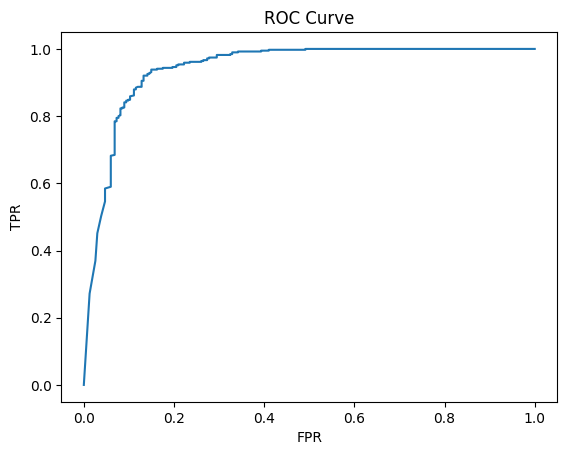

In [ ]:
plt.title('ROC Curve')
plt.plot(roc[0], roc[1])
plt.xlabel('FPR')
plt.ylabel('TPR');

In [ ]:
print('ROC-AUC:', round(roc_auc_score(true_labels, labels), 3))

ROC-AUC: 0.942


Для хороших предсказаний с низким количеством FPR пришлось взять довольно большую засечку: на уровне 0.99995

In [ ]:
preds = (labels > 0.99995).float()
print('precision:', precision_score(true_labels, preds).round(3))
print('recall:', recall_score(true_labels, preds).round(3))
print('f1-score:', f1_score(true_labels, preds).round(3))

precision: 0.906
recall: 0.938
f1-score: 0.922


In [ ]:
cm = confusion_matrix(true_labels, (labels > 0.99995).float())
disp = ConfusionMatrixDisplay(cm)

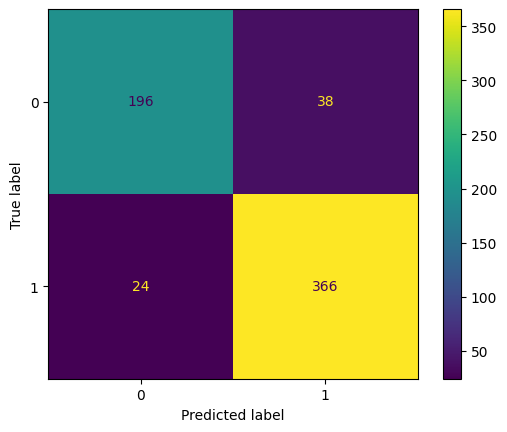

In [ ]:
disp.plot();

Конечно, в задаче такого плана, нам гораздо важнее не упустить больного пациента, поэтому, возможно, засечку стоит поставить на меньшем уровне. Число FP-предсказаний подрастет, однако recall покажет лучший результат.

In [134]:
torch.save(xray_classifier.state_dict(), 'model_weights.pth')